In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from klampt.math import vectorops,so3,se3
import math
import os

def read_scan(dataset,scan):
    """Returns a scan as a tuple (T,pts) where T is a Klampt se3 element"""
    pose = None
    points = []
    with open(os.path.join(dataset,scan+".pose"),'r') as f:
        trans = [float(x) for x in f.readline().split()]
        if len(trans) != 3:
            raise IOError("Pose translation doesn't have 3 elements?")
        euler = [float(x) for x in f.readline().split()]
        if len(euler) != 3:
            raise IOError("Pose euler angles doesn't have 3 elements?")
        #euler angles are euler x, euler y, euler z in degrees
        R = so3.from_rpy([math.radians(v) for v in euler])
        pose = (R,trans)
    with open(os.path.join(dataset,scan+".3d"),'r') as f:
        for line in f.readlines():
            pt = [float(x) for x in line.split()]
            if len(pt) == 0:
                continue
            if len(pt) != 3:
                raise IOError("Point doesn't have 3 elements?")
            points.append(pt)
    #points are in left-handed coordinates, convert to right-handed
    points = np.array(points)
    points[:,2] *= -1
    return pose,points

def transform_pc(pc,T,point_channels=[0,1,2],normal_channels=[6,7,8]):
    """Given a point cloud `pc` and a transform T, apply the transform
    to the point cloud (in place).
    
    Args:
        pc (np.ndarray): an N x M numpy array, with N points and M
            channels.
        T (klampt se3 element): a Klamp't se3 element representing
            the transform to apply.
        point_channels (list of 3 ints): The channel indices (columns)
             in pc corresponding to the point data.
        normal_channels (list of 3 ints): The channels indices(columns)
            in pc corresponding to the normal data.  If this is None
            or an index is >= M, just ignore.
    """
    N,M = pc.shape
    assert len(point_channels) == 3
    for i in point_channels:
        assert i < M,"Invalid point_channel"
    #tranform the points
    for i in range(N):
        #extract a length-M array from pc
        point_data = pc[i,:]
        
        #do something to the point_data
        point = point_data[point_channels]
        point_data[point_channels] = se3.apply(T,point)
        
    if normal_channels is not None and normal_channels[0] < M:
        for i in normal_channels:
            assert i < M,"Invalid normal_channel"
        for i in range(N):
            #extract a length-M array from pc
            point_data = pc[i,:]

            #do something to the point_data
            point = point_data[normal_channels]
            point_data[normal_channels] = so3.apply(T[0],point)

def hsv2rgb(h, s, v):
    """Hue-saturation-value to RGB. Output channels are in the range [0,1]"""
    h60 = h / 60.0
    h60f = math.floor(h60)
    hi = int(h60f) % 6
    f = h60 - h60f
    p = v * (1 - s)
    q = v * (1 - f * s)
    t = v * (1 - (1 - f) * s)
    r, g, b = 0, 0, 0
    if hi == 0: r, g, b = v, t, p
    elif hi == 1: r, g, b = q, v, p
    elif hi == 2: r, g, b = p, v, t
    elif hi == 3: r, g, b = p, q, v
    elif hi == 4: r, g, b = t, p, v
    elif hi == 5: r, g, b = v, p, q
    return r, g, b
    
def rgb2hsv(r, g, b):
    """RGB to Hue-saturation-value. Input channels are in the range [0,1]"""
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = df/mx
    v = mx
    return h, s, v

In [70]:
#Basic plane fitting utilities

def fit_plane3(point1,point2,point3):
    """Returns a 3D plane equation fitting the 3 points.
    
    The result is (a,b,c,d) with the plane equation ax+by+cz+d=0
    """
    normal = np.cross(point2-point1,point3-point1)
    nlen = np.linalg.norm(normal)
    if nlen < 1e-4:
        #degenerate
        raise ValueError("Points are degenerate")
    normal = normal / nlen
    offset = -np.dot(normal,point1)
    return (normal[0],normal[1],normal[2],offset)


def fit_plane(points):
    """Returns a 3D plane equation that is a least squares fit
    through the points (len(points) >= 3)."""
    if len(points)<3:
        raise ValueError("Need to have at least 3 points to fit a plane")
    #if len(points)==3:
    #    return fit_plane3(points[0],points[1],points[2])
    centroid = np.average(points,axis=0)
    U,W,Vt = np.linalg.svd(points-[centroid]*len(points))
    normal = Vt[2,:]
    return normal[0],normal[1],normal[2],-np.dot(centroid,normal)


class PlaneFitter:
    """
    Online fitting of planes through 3D point clouds
    
    Attributes:
        normal (3-vector): best-fit normal
        centroid (3-vector): centroid of points
        count (int): # of points
        sse (float): fitting sum of squared errors
        cov (3x3 array): covariance of points
    """
    def __init__(self,points=None):
        if points is None:
            self.count = 0
            self.centroid = np.zeros(3)
            self.cov = np.zeros((3,3))
            self.normal = np.array([0,0,1])
            self.sse = 0
        else:
            self.count = len(points)
            self.centroid = np.average(points,axis=0)
            pprime = points - [self.centroid]*len(points)
            self.cov = np.dot(pprime.T,pprime)/self.count
            self._update_plane()
    
    def plane_equation(self):
        """Returns (a,b,c,d) with ax+by+cz+d=0 the plane equation"""
        offset = np.dot(self.centroid,self.normal)
        return (self.normal[0],self.normal[1],self.normal[2],-offset)
    
    def goodness_of_fit(self):
        """Returns corrected RMSE"""
        if self.count <= 3:
            return float('inf')
        return math.sqrt(self.sse*self.count / (self.count-3))
    
    def add_point(self,pt):
        """Online estimation of best fit plane"""
        new_count = self.count + 1
        new_centroid = self.centroid + (pt-self.centroid)/new_count
        old_sse = (self.cov + np.outer(self.centroid,self.centroid))*self.count
        new_sse = old_sse + np.outer(pt,pt)
        new_cov = new_sse/new_count - np.outer(new_centroid,new_centroid)
        self.count = new_count
        self.centroid = new_centroid
        self.cov = new_cov
        self._update_plane()
    
    def merge(self,fitter,inplace = False):
        """Online merging of two plane fitters. 
        
        If inplace = False, returns a new PlaneFitter.
        If inplace = True, self is updated with the result.
        """
        if not inplace:
            res = PlaneFitter()
        else:
            res = self
        new_count = self.count + fitter.count
        old_sum = self.centroid*self.count
        new_sum = old_sum + fitter.centroid*fitter.count
        new_centroid = new_sum/new_count
        old_sse = (self.cov + np.outer(self.centroid,self.centroid))*self.count
        fitter_sse = (fitter.cov + np.outer(fitter.centroid,fitter.centroid))*fitter.count
        new_sse = old_sse + fitter_sse
        new_cov = new_sse/new_count - np.outer(new_centroid,new_centroid)
        res.count = new_count
        res.centroid = new_centroid
        res.cov = new_cov
        res._update_plane()
        return res
    
    def distance(self,pt):
        """Returns the signed distance to this plane"""
        return np.dot(self.normal,pt)-np.dot(self.normal,self.centroid)

    def _update_plane(self):
        w,v = np.linalg.eig(self.cov)
        index = np.argmin(w)
        self.normal = v[:,index]
        self.sse = self.count * np.dot(self.normal,np.dot(self.cov,self.normal))

# #these should all be the same up to a sign change
# points = np.array([[0.5,0.0,9],[1,1,10],[-1,-1,10]])
# print(fit_plane3(points[0],points[1],points[2]))
# print(fit_plane(points))
# print(PlaneFitter(points).plane_equation())
# fitter = PlaneFitter()
# fitter.add_point(points[0])
# fitter.add_point(points[1])
# fitter.add_point(points[2])
# print(fitter.plane_equation())

(0.6666666666666666, -0.6666666666666666, 0.3333333333333333, -3.3333333333333335)
(0.6666666666666666, -0.6666666666666669, 0.33333333333333354, -3.3333333333333353)
(0.6666666666666665, -0.6666666666666666, 0.3333333333333336, -3.3333333333333357)
(0.666666666666672, -0.6666666666666743, 0.3333333333333078, -3.333333333333087)


In [71]:
# #Read in a scan from a dataset

# DATASET = "hannover1/"
# SCAN = "scan013"

# T,pts = read_scan(DATASET,SCAN)
# flipyz = so3.rotation((1,0,0),math.pi/2)
# transform_pc(pts,(flipyz,[0,0,0]))
# #transform_pc(pts,T)

In [72]:
# #Run me to generate a two-plane dataset by random sampling
# fake_wall_pts = []
# for i in range(4000):
#     fake_wall_pts.append([np.random.uniform(500,1500),np.random.uniform(-500,500),100])
# for i in range(1000):
#     fake_wall_pts.append([500,np.random.uniform(-500,500),np.random.uniform(100,1000)])
# fake_wall_pts = np.array(fake_wall_pts)
# R = np.array(so3.matrix(so3.rotation((0,0,1),math.radians(30))))
# fake_wall_pts = fake_wall_pts.dot(R)

# #uncomment me to test on the plane dataset
# #pts = fake_wall_pts

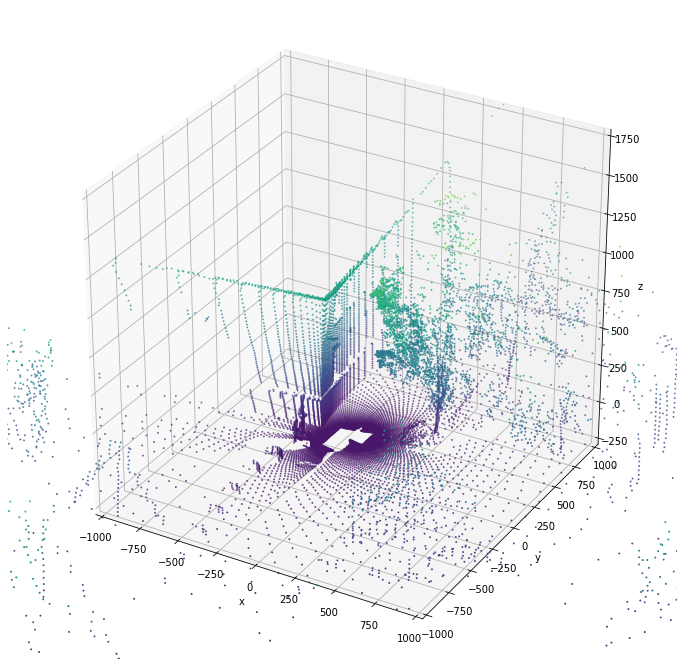

KlamptWidget(scene={'metadata': {'version': 4.4, 'type': 'Object', 'fullscene': True, 'generator': 'Klampt thrâ€¦

In [94]:
# #Matplotlib plot

# fig = plt.figure(figsize=(12,12))
# ax = plt.axes(projection='3d')
# ax.scatter(pts[:,0],pts[:,1],pts[:,2],s=1,c=pts[:,2])
# #ax.view_init(elev=90, azim=0)
# ax.set_xlim(-1000,1000)
# ax.set_ylim(-1000,1000)
# ax.set_zlim(-250,1750)
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_zlabel("z")
# plt.show()

# from klampt import WorldModel
# from klampt.vis.ipython import KlamptWidget
# world = WorldModel()
# kvis = KlamptWidget(world)
# display(kvis)

In [74]:
def add_pc_to_vis(kvis,pc,clear=True,color='z',subsample=None,name_prefix='p'):
    if clear:
        kvis.clearExtras()
    if subsample is not None:
        if not isinstance(color,str) and hasattr(color,'__iter__'):
            assert len(color) == len(pc)
            color = [color[v] for v in range(0,len(pc),subsample)]
        pc = pc[range(0,len(pc),subsample)]
    colors = []
    colorval = None
    if color=='z':
        colorval= pc[:,2]
    elif color=='x':
        colorval= pc[:,0]
    elif color=='y':
        colorval= pc[:,1]
    elif not isinstance(color,str) and hasattr(color,'__iter__'):
        assert len(color) == len(pc)
        if hasattr(color[0],'__iter__'):
            colors = color
        else:
            colors = [color]*len(pc)
    else:
        raise ValueError("Can't handle color value "+str(color))
    if colorval is not None:
        vmax = np.max(colorval)
        vmin = np.min(colorval)
        if vmin == vmax:
            colors = np.ones((len(pc)),3)
        else:
            inv_denom = 1.0/(vmax-vmin)
            colorval = (colorval-vmin)*inv_denom
            colors = np.array([hsv2rgb(v*240,1,1) for v in colorval])
            #colors = np.column_stack((colorval,colorval,colorval))
    print("Adding",pc.shape[0],"points to visualization")
    kvis.beginRpc()
    for i in range(pc.shape[0]):
        x,y,z = pc[i]
        name = name_prefix+str(i)
        kvis.addSphere(name,x,y,z,r=0.01)
        kvis.setColor(name,*colors[i])
    kvis.endRpc()

# add_pc_to_vis(kvis,pts*0.001,subsample=9)

Adding 1758 points to visualization


In [75]:
def plot_fitter(kvis,fitter,name,color=None):
    centroid = fitter.centroid
    v,w = np.linalg.eig(fitter.cov)
    #R = so3.canonical(fitter.normal)
    #x = so3.apply(R,[0,1,0])
    #y = so3.apply(R,[0,0,1])
    nindex = np.argmin(v)
    xaxis = (nindex + 1)%3
    yaxis = (nindex + 2)%3
    x = w[:,xaxis]
    y = w[:,yaxis]
    xvar = np.dot(x,np.dot(fitter.cov,x))
    yvar = np.dot(y,np.dot(fitter.cov,y))
    width = math.sqrt(xvar)*2
    height = math.sqrt(yvar)*2
    x=np.array(x)*width
    y=np.array(y)*height
    a = centroid-x-y
    b = centroid+x-y
    c = centroid+x+y
    d = centroid-x+y
    kvis.addQuad(name,list(a),list(b),list(c),list(d))
    kvis.addQuad(name+'b',list(d),list(c),list(b),list(a))
    if color is not None:
        kvis.setColor(name,*color)
        kvis.setColor(name+'b',*color)

def plot_fitters(kvis,fitters,clear=True,name_prefix="pl",colors=None):
    if clear:
        kvis.clearExtras()
    if colors is None:
        colors = [(1,0,0),(0,1,0),(0,0,1),(1,1,0),(1,0,1),(1,0,1)]
    items = []
    kvis.beginRpc()
    for i in range(len(fitters)):
        if i < len(colors):
            color = colors[i]
        else:
            color = np.random.uniform(size=3)
        items.append(name_prefix+str(i))
        plot_fitter(kvis,fitters[i],items[-1],color)
    kvis.endRpc()
    return items

In [102]:
from collections import defaultdict

def pts_to_grid(pts,res):
    """Returns a dict mapping grid cells to point-cloud indices.
    
    Return value is of type
    
        dict[3-tuple] -> list of ints
        
    where each int is an index into the pts array.
    """
    grid = defaultdict(list)
    invres = 1.0/res
    inds = np.floor(pts[:,:3]*invres).astype(int)
    for i in range(pts.shape[0]):
        ind = tuple(inds[i])
        grid[ind].append(i)
    return grid

def fit_planes_ransac(pts,ntries,inlier_threshold=0.05,inlier_count=10):
    """Returns a list of PlaneFitters that may fit the given point cloud.
    
    TODO: Problem A: find a way to avoid sampling more than 1 plane for a flat surface.
    After this is done, the return value is (planes,assignments) where 
    assignments is a list of len(pts) integers, giving the index of the plane
    to which a point is assigned.  The assignment should be -1 if no plane
    is assigned.
    """
    planes = []
    point_assignments = np.array([-1]*len(pts))
    point_indices = range(len(pts))
    outliers = list(point_indices)
    for tries in range(ntries):
        if len(outliers) < inlier_count+3:
            break
        subset = np.random.choice(outliers,3,replace=False)
        try:
            plane = fit_plane3(pts[subset[0]],pts[subset[1]],pts[subset[2]])
        except ValueError:
            continue
        inliers = []
        sumabserr = 0
        for i in outliers:
            assert point_assignments[i] < 0
            pt = pts[i]
            err = np.dot(pt,plane[:3])+plane[3]
            sumabserr += abs(err)
            if abs(err) < inlier_threshold:
                inliers.append(i)
            if abs(err) > 0.5 and False:
                print("Uh... weird plane?")
                print("Fit points",pts[subset[0]],pts[subset[1]],pts[subset[2]])
                print("Plane",plane)
                print("Test point",pt)
                print("Error",err)
                break
        #print("Mean average error for plane",tries,"is",sumabserr/len(pts),"with",len(inliers),"inliers")
        if len(inliers)-3 >= inlier_count:
            point_assignments[inliers] = len(planes)
            planes.append(PlaneFitter(pts[inliers]))
            outliers = list(set(outliers) - set(inliers))
    #return planes
    #at the end of Problem A, you will return this
    return planes,point_assignments


def plane_distance(fitter1,fitter2):
    """Returns a distance metric between two planes."""
    return max(abs(fitter1.distance(fitter2.centroid)),abs(fitter2.distance(fitter1.centroid)))


def fit_planes_grid(pts,grid_res,inlier_threshold,inlier_count=10):
    """Converts points to a grid and performs ransac fitting on each grid cell.
    """
    grid = pts_to_grid(pts,grid_res)
    print(len(grid),"grid cells occupied")
    output_planes = []
    pt_to_plane = np.full(len(pts),-1)   #maps points to planes, or -1 if no plane is associated
    cell_to_planes = dict()   #maps grid cells to plane indices (will be helpful later)
    plane_to_cells = []       #maps planes to lists of grid cells (will be helpful later)
    for (cell,indices) in grid.items():
        subset = pts[indices]
        #select some number of RANSAC iterations
        if len(indices) < inlier_count+3:
            continue
        if len(indices) < inlier_count*2:
            niters = 10
        elif len(indices) < inlier_count*4:
            niters = 20
        else:
            niters = 40
        #Use RANSAC to get a set of planes fitting this cell
        gridplanes,pt_assignments = fit_planes_ransac(subset,niters,inlier_threshold,inlier_count)
        plane_index_start = len(output_planes)
        output_planes += gridplanes
        
        #Do some bookeeping to keep track of cell assignments
        plane_ids = []
        for plane_id,p in enumerate(gridplanes):
            plane_ids.append(plane_index_start + plane_id)
            plane_to_cells.append([cell])
        cell_to_planes[cell] = plane_ids
        
        #Do some bookkeeping to keep track of point assignments for the full point cloud
        for pt,plane_id in zip(indices,pt_assignments):
            if plane_id >= 0:
                assert pt_to_plane[pt] == -1
                pt_to_plane[pt] = plane_index_start+plane_id
            else:
                pt_to_plane[pt] = -1
    assert len(plane_to_cells) == len(output_planes)
                
    #TODO: Problem B: do region growing
    #return output_planes,pt_to_plane

    cell_deltas = [(0,0,0),(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]
    #Do some bookkeeping
    plane_to_pts = [[] for p in output_planes]
    for pt,plane in enumerate(pt_to_plane):
        if plane >= 0:
            plane_to_pts[plane].append(pt)
    
    #Declare some helper functions
    def neighbors(cell):
        #iterates over occupied neighbors of a given cell
        for delta in cell_deltas:
            neighbor = tuple(vectorops.add(cell,delta))
            if neighbor in grid:
                yield neighbor
        return
            
    def merge_planes(i,j):
        #merges plane index j into plane index i, doing all the bookkeeping needed to maintain
        #the plane_to_cell/cell_to_planes/pt_to_plane/plane_to_pts data structures. 
        #output_plane[j] is discarded.
        output_planes[i].merge(output_planes[j],inplace=True)
        output_planes[j] = None
        plane_to_cells[i] += plane_to_cells[j]
        for cell in plane_to_cells[j]:
            cell_to_planes[cell].remove(j)
        plane_to_cells[j] = []
        for pt in plane_to_pts[j]:
            pt_to_plane[pt] = pindex
        plane_to_pts[i] += plane_to_pts[j]
        plane_to_pts[j] = []
        
    for pindex,p in enumerate(output_planes):
        if p is None: continue
        pcells = plane_to_cells[pindex]
        cellindex = 0
        while cellindex < len(pcells):
            cell = pcells[cellindex]
            print("Check cell",cell,",",cellindex,"of",len(pcells))
            cellindex += 1
            for neighbor in neighbors(cell):
                if neighbor in pcells: continue
                print("  Check neighboring cell",neighbor)
                #see if you can merge neighbors' planes
                for nplane_index in cell_to_planes.get(neighbor,[]):
                    if nplane_index <= pindex:
                        continue
                    if output_planes[nplane_index] is None:
                        continue
                    nplane = output_planes[nplane_index]
                    if plane_distance(p,nplane) < inlier_threshold*3:
                        print("  Merging plane",pindex,"and",nplane_index,"adding cells",plane_to_cells[nplane_index])
                        merge_planes(pindex,nplane_index)
                    else:
                        print("  Not merging plane",pindex,"and",nplane_index,"distance",plane_distance(p,nplane))
                #see if you can add more of the neighbor's points to p
                outliers_added = False
                for nptindex in grid[neighbor]:
                    if pt_to_plane[nptindex] < 0:
                        if abs(p.distance(pts[nptindex])) < inlier_threshold:
                            p.add_point(pts[nptindex])
                            plane_to_pts[pindex].append(nptindex)
                            pt_to_plane[nptindex] = pindex
                            outliers_added = True
                if outliers_added:
                    pcells.append(neighbor)
    
    num_dropped = 0
    for i,p in enumerate(output_planes):
        if p is None: continue
        if len(plane_to_pts[i]) < inlier_count*2:
            num_dropped += 1
            output_planes[i] = None
            for pt in plane_to_pts[i]:
                pt_to_plane[pt] = -1
                
    for i,iplane in enumerate(pt_to_plane):
        if iplane >= 0 and output_planes[iplane] is None:
            raise ValueError("Invalid maintenance of point-to-plane indexing data structure, point %s has invalid plane %s"%(i,iplane))
            
    #The following code debugs and remaps the results of region growing
    plane_collapse_map = dict()
    collapse_output_planes = []
    for i,p in enumerate(output_planes):
        if p is not None:
            plane_collapse_map[i] = len(collapse_output_planes)
            collapse_output_planes.append(p)
        else:
            plane_collapse_map[i] = None
    plane_collapse_map[-1] = -1
    
    print("Merged from",len(output_planes),"to",len(collapse_output_planes),"planes")
    for i in range(len(pt_to_plane)):
        pt_to_plane[i] = plane_collapse_map[pt_to_plane[i]]
        assert pt_to_plane[i] is not None
    return collapse_output_planes,pt_to_plane



In [103]:
# NUM_POINTS_TO_DRAW = 2000

def debug_plane_fitting(method,pts,*args,**kwargs):
    if method=='ransac':
        planes,assignments = fit_planes_ransac(pts,*args,**kwargs)
    elif method=='grid':
        planes,assignments = fit_planes_grid(pts,*args,**kwargs)
    else:
        raise ValueError("Can only accept ransac or grid fitting")
    print("Found",len(planes),"planes to fit")
    plane_colors = [np.random.uniform(size=3) for i in range(np.max(assignments)+1)]
    colors = []
    for i in range(len(pts)):
        if assignments[i] < 0:
            colors.append((0,0,0))
        else:
            colors.append(plane_colors[assignments[i]])
    add_pc_to_vis(kvis,pts,subsample=int(math.floor(len(pts)/NUM_POINTS_TO_DRAW)),color=colors)
    kvis_planes = plot_fitters(kvis,planes,clear=False,colors=plane_colors)

In [107]:
#debug_plane_fitting('ransac',fake_wall_pts*0.001,ntries=100,inlier_threshold=0.005,inlier_count=100)
#Not useful...
#debug_plane_fitting('ransac',pts*0.001,ntries=100,inlier_threshold=0.005,inlier_count=400)
# Uncomment to show on Hannover point cloud
# debug_plane_fitting('grid',pts*0.001,0.1,inlier_threshold=0.005,inlier_count=10)
#Uncomment to show on fake wall point cloud
#debug_plane_fitting('grid',fake_wall_pts*0.001,0.1,inlier_threshold=0.005,inlier_count=10)

2195 grid cells occupied
Check cell (-1, -4, 0) , 0 of 1
  Check neighboring cell (-2, -4, 0)
  Merging plane 0 and 7 adding cells [(-2, -4, 0)]
  Check neighboring cell (-1, -3, 0)
  Merging plane 0 and 4 adding cells [(-1, -3, 0)]
  Check neighboring cell (-1, -5, 0)
  Merging plane 0 and 1 adding cells [(-1, -5, 0)]
  Check neighboring cell (-1, -4, -1)
Check cell (-2, -4, 0) , 1 of 7
  Check neighboring cell (-3, -4, 0)
  Not merging plane 0 and 14 distance 0.16951532494018212
  Not merging plane 0 and 15 distance 0.029187513363798878
  Merging plane 0 and 16 adding cells [(-3, -4, 0)]
  Check neighboring cell (-2, -3, 0)
  Not merging plane 0 and 8 distance 0.05123294047325233
  Merging plane 0 and 9 adding cells [(-2, -3, 0)]
  Not merging plane 0 and 11 distance 0.044069849581628746
  Merging plane 0 and 12 adding cells [(-2, -3, 0)]
  Check neighboring cell (-2, -5, 0)
  Merging plane 0 and 6 adding cells [(-2, -5, 0)]
Check cell (-2, -4, 0) , 2 of 11
Check cell (-1, -3, 0) , 3

  Check neighboring cell (-1, -13, 0)
Check cell (-8, -6, 0) , 91 of 112
  Check neighboring cell (-9, -6, 0)
  Check neighboring cell (-8, -5, 0)
  Check neighboring cell (-8, -7, 0)
Check cell (-7, -5, 0) , 92 of 114
  Check neighboring cell (-7, -4, 0)
Check cell (-8, -2, 0) , 93 of 115
Check cell (-7, -3, 0) , 94 of 115
  Check neighboring cell (-7, -3, -1)
Check cell (-7, -2, -1) , 95 of 116
Check cell (-5, -3, 0) , 96 of 116
  Check neighboring cell (-5, -3, -1)
Check cell (-6, -4, 0) , 97 of 117
Check cell (-6, -3, -1) , 98 of 117
Check cell (-3, 2, -1) , 99 of 117
  Check neighboring cell (-3, 3, -1)
  Check neighboring cell (-3, 2, 0)
  Not merging plane 0 and 99 distance 0.17957232062132844
Check cell (-3, 2, -1) , 100 of 118
  Check neighboring cell (-3, 2, 0)
  Not merging plane 0 and 99 distance 0.17957232062132844
Check cell (-2, 3, -1) , 101 of 118
  Check neighboring cell (-2, 4, -1)
  Merging plane 0 and 127 adding cells [(-2, 4, -1)]
Check cell (2, 1, -1) , 102 of 119

Check cell (-2, -3, 0) , 0 of 1
  Check neighboring cell (-1, -3, 0)
  Check neighboring cell (-3, -3, 0)
  Not merging plane 8 and 21 distance 0.0746311419605887
  Check neighboring cell (-2, -2, 0)
  Not merging plane 8 and 18 distance 0.02284074063856492
  Not merging plane 8 and 19 distance 0.02594903812603014
  Not merging plane 8 and 20 distance 0.019449439994836892
  Check neighboring cell (-2, -4, 0)
  Check neighboring cell (-2, -3, 1)
Check cell (-2, -3, 0) , 0 of 1
  Check neighboring cell (-1, -3, 0)
  Check neighboring cell (-3, -3, 0)
  Not merging plane 10 and 21 distance 0.025977349717404605
  Check neighboring cell (-2, -2, 0)
  Not merging plane 10 and 18 distance 0.09794234091981519
  Not merging plane 10 and 19 distance 0.08839145855570943
  Not merging plane 10 and 20 distance 0.09261589621661745
  Check neighboring cell (-2, -4, 0)
  Check neighboring cell (-2, -3, 1)
Check cell (-2, -3, 1) , 1 of 2
  Check neighboring cell (-3, -3, 1)
  Not merging plane 10 and 2

  Not merging plane 25 and 45 distance 0.11131501416123915
  Check neighboring cell (-3, 0, 1)
  Not merging plane 25 and 52 distance 0.06929759653160011
  Not merging plane 25 and 53 distance 0.11083945931742982
  Not merging plane 25 and 54 distance 0.0776312784355816
  Check neighboring cell (-3, -1, 2)
Check cell (-3, -2, 0) , 0 of 1
  Check neighboring cell (-2, -2, 0)
  Check neighboring cell (-4, -2, 0)
  Check neighboring cell (-3, -1, 0)
  Not merging plane 26 and 37 distance 0.07780828537697894
  Check neighboring cell (-3, -3, 0)
  Check neighboring cell (-3, -2, 1)
  Not merging plane 26 and 33 distance 0.026869046005514124
  Not merging plane 26 and 34 distance 0.022020859918147367
  Check neighboring cell (-3, -2, -1)
Check cell (-3, -1, 0) , 1 of 2
  Check neighboring cell (-2, -1, 0)
  Check neighboring cell (-4, -1, 0)
  Not merging plane 26 and 42 distance 0.11766486392673706
  Check neighboring cell (-3, 0, 0)
  Not merging plane 26 and 57 distance 0.1700005331197613

Check cell (-5, -1, 3) , 12 of 15
  Check neighboring cell (-5, -1, 4)
Check cell (-6, -1, 3) , 13 of 16
  Check neighboring cell (-7, -1, 3)
  Check neighboring cell (-6, -1, 4)
Check cell (-4, 0, 2) , 14 of 18
  Check neighboring cell (-3, 0, 2)
  Not merging plane 42 and 60 distance 0.01882164329428622
  Not merging plane 42 and 61 distance 0.19783696258796857
  Not merging plane 42 and 62 distance 0.23220632371595334
  Merging plane 42 and 63 adding cells [(-3, 0, 2)]
  Check neighboring cell (-4, 0, 3)
  Merging plane 42 and 50 adding cells [(-4, 0, 3)]
Check cell (-5, -1, 4) , 15 of 20
  Check neighboring cell (-5, 0, 4)
Check cell (-7, -1, 3) , 16 of 21
  Check neighboring cell (-7, -1, 4)
Check cell (-6, -1, 4) , 17 of 22
  Check neighboring cell (-6, -1, 5)
Check cell (-3, 0, 2) , 18 of 23
  Check neighboring cell (-3, 1, 2)
  Not merging plane 42 and 89 distance 0.22148197421065943
  Check neighboring cell (-3, -1, 2)
  Check neighboring cell (-3, 0, 3)
  Not merging plane 42

  Not merging plane 52 and 116 distance 0.05736816908588882
  Not merging plane 52 and 117 distance 0.05352145888424595
  Check neighboring cell (-3, 3, -1)
Check cell (-3, 2, 1) , 12 of 21
  Check neighboring cell (-3, 2, 2)
  Not merging plane 52 and 101 distance 0.05132543982997939
  Not merging plane 52 and 102 distance 0.1555170802659464
Check cell (-2, 0, 0) , 13 of 21
  Check neighboring cell (-2, -1, 0)
  Check neighboring cell (-2, 0, 1)
  Not merging plane 52 and 79 distance 0.017327076168517974
  Check neighboring cell (-2, 0, -1)
Check cell (-3, 0, 4) , 14 of 21
  Check neighboring cell (-4, 0, 4)
  Check neighboring cell (-3, 0, 5)
  Merging plane 52 and 73 adding cells [(-3, 0, 5)]
Check cell (-3, 3, 3) , 15 of 22
  Check neighboring cell (-3, 4, 3)
  Check neighboring cell (-3, 3, 4)
  Merging plane 52 and 118 adding cells [(-3, 3, 4)]
  Check neighboring cell (-3, 3, 2)
  Merging plane 52 and 110 adding cells [(-3, 3, 2)]
Check cell (-3, 2, 4) , 16 of 25
  Check neighbo

  Check neighboring cell (-3, -1, 1)
  Check neighboring cell (-3, 0, 2)
  Check neighboring cell (-3, 0, 0)
Check cell (-3, 2, 2) , 3 of 5
  Check neighboring cell (-3, 3, 2)
  Check neighboring cell (-3, 1, 2)
  Check neighboring cell (-3, 2, 3)
  Not merging plane 88 and 103 distance 0.06791688984573817
  Not merging plane 88 and 104 distance 0.0656020898526213
Check cell (-2, 0, 1) , 4 of 5
  Check neighboring cell (-2, 0, 0)
Check cell (-3, 1, 7) , 0 of 1
  Check neighboring cell (-3, 2, 7)
  Merging plane 94 and 107 adding cells [(-3, 2, 7)]
  Check neighboring cell (-3, 0, 7)
  Check neighboring cell (-3, 1, 8)
  Check neighboring cell (-3, 1, 6)
Check cell (-3, 2, 7) , 1 of 3
  Check neighboring cell (-3, 3, 7)
  Check neighboring cell (-3, 2, 8)
  Check neighboring cell (-3, 2, 6)
Check cell (-3, 1, 8) , 2 of 5
  Check neighboring cell (-2, 1, 8)
  Not merging plane 94 and 97 distance 0.042262844512697906
  Check neighboring cell (-3, 2, 8)
  Check neighboring cell (-3, 0, 8)


  Check neighboring cell (1, 1, 7)
  Not merging plane 140 and 151 distance 0.1100312367647901
  Check neighboring cell (1, 2, 6)
  Not merging plane 140 and 147 distance 0.10891102647413664
Check cell (2, 2, 7) , 4 of 6
  Check neighboring cell (3, 2, 7)
  Check neighboring cell (2, 3, 7)
  Check neighboring cell (2, 1, 7)
  Check neighboring cell (2, 2, 6)
Check cell (1, 3, 7) , 5 of 7
  Check neighboring cell (0, 3, 7)
  Check neighboring cell (1, 3, 8)
  Check neighboring cell (1, 3, 6)
Check cell (2, 3, 7) , 6 of 7
  Check neighboring cell (3, 3, 7)
  Check neighboring cell (2, 3, 8)
  Check neighboring cell (2, 3, 6)
Check cell (1, 2, 7) , 0 of 1
  Check neighboring cell (2, 2, 7)
  Check neighboring cell (0, 2, 7)
  Check neighboring cell (1, 3, 7)
  Check neighboring cell (1, 1, 7)
  Not merging plane 146 and 151 distance 0.09018458583003797
  Check neighboring cell (1, 2, 8)
  Check neighboring cell (1, 2, 6)
  Not merging plane 146 and 147 distance 0.0852008708531557
Check ce

  Not merging plane 150 and 195 distance 0.07043904987390581
  Not merging plane 150 and 196 distance 0.057425334740761946
  Check neighboring cell (1, -1, 9)
  Check neighboring cell (1, 0, 10)
  Check neighboring cell (1, 0, 8)
  Not merging plane 150 and 172 distance 0.06941258834768049
Check cell (1, -1, 9) , 4 of 5
  Check neighboring cell (2, -1, 9)
  Check neighboring cell (1, -1, 10)
Check cell (2, -1, 9) , 5 of 6
  Check neighboring cell (3, -1, 9)
  Check neighboring cell (2, 0, 9)
  Not merging plane 150 and 195 distance 0.060920640889761124
  Not merging plane 150 and 196 distance 0.04703434004803386
  Check neighboring cell (2, -2, 9)
  Check neighboring cell (2, -1, 8)
Check cell (2, -2, 9) , 6 of 7
  Check neighboring cell (3, -2, 9)
Check cell (3, -2, 9) , 7 of 8
  Check neighboring cell (3, -1, 9)
  Check neighboring cell (3, -2, 8)
Check cell (1, 1, 7) , 0 of 1
  Check neighboring cell (2, 1, 7)
  Check neighboring cell (0, 1, 7)
  Check neighboring cell (1, 2, 7)
  C

  Check neighboring cell (5, 0, 5)
  Check neighboring cell (5, 1, 6)
  Check neighboring cell (5, 1, 4)
Check cell (4, 2, 5) , 6 of 9
  Check neighboring cell (3, 2, 5)
  Check neighboring cell (4, 3, 5)
  Check neighboring cell (4, 2, 6)
  Check neighboring cell (4, 2, 4)
  Not merging plane 163 and 174 distance 0.2106640384928508
Check cell (4, 1, 6) , 7 of 10
  Check neighboring cell (5, 1, 6)
  Check neighboring cell (4, 2, 6)
  Check neighboring cell (4, 0, 6)
Check cell (3, 0, 6) , 8 of 10
  Check neighboring cell (4, 0, 6)
  Check neighboring cell (2, 0, 6)
  Check neighboring cell (3, -1, 6)
  Check neighboring cell (3, 0, 7)
  Check neighboring cell (3, 0, 5)
  Not merging plane 163 and 194 distance 0.0899981540719681
Check cell (4, 2, 4) , 9 of 11
  Check neighboring cell (5, 2, 4)
  Check neighboring cell (4, 3, 4)
  Check neighboring cell (4, 1, 4)
  Not merging plane 163 and 187 distance 0.14691931380903195
  Check neighboring cell (4, 2, 3)
  Not merging plane 163 and 17

  Check neighboring cell (4, 1, 5)
  Check neighboring cell (4, -1, 5)
  Check neighboring cell (4, 0, 6)
  Check neighboring cell (4, 0, 4)
Check cell (3, -1, 5) , 4 of 8
  Check neighboring cell (2, -1, 5)
  Check neighboring cell (3, -1, 6)
  Check neighboring cell (3, -1, 4)
Check cell (5, 0, 5) , 5 of 8
  Check neighboring cell (6, 0, 5)
  Check neighboring cell (5, 1, 5)
  Check neighboring cell (5, -1, 5)
  Check neighboring cell (5, 0, 6)
  Check neighboring cell (5, 0, 4)
  Not merging plane 168 and 197 distance 0.1457023587633881
Check cell (4, 1, 5) , 6 of 10
  Check neighboring cell (3, 1, 5)
  Check neighboring cell (4, 2, 5)
  Check neighboring cell (4, 1, 6)
  Check neighboring cell (4, 1, 4)
  Not merging plane 168 and 187 distance 0.18039479454891644
Check cell (4, -1, 5) , 7 of 10
  Check neighboring cell (4, -1, 6)
  Check neighboring cell (4, -1, 4)
Check cell (5, 1, 5) , 8 of 11
  Check neighboring cell (6, 1, 5)
  Check neighboring cell (5, 1, 6)
  Check neighbori

  Check neighboring cell (4, 1, 4)
  Check neighboring cell (4, 1, 2)
Check cell (4, 1, 4) , 1 of 3
  Check neighboring cell (5, 1, 4)
  Check neighboring cell (3, 1, 4)
  Check neighboring cell (4, 2, 4)
  Check neighboring cell (4, 0, 4)
  Check neighboring cell (4, 1, 5)
Check cell (4, 1, 2) , 2 of 4
  Check neighboring cell (5, 1, 2)
  Check neighboring cell (4, 2, 2)
Check cell (4, 1, 5) , 3 of 5
  Check neighboring cell (5, 1, 5)
  Check neighboring cell (3, 1, 5)
  Check neighboring cell (4, 2, 5)
  Check neighboring cell (4, 0, 5)
  Check neighboring cell (4, 1, 6)
Check cell (4, 2, 2) , 4 of 7
  Check neighboring cell (4, 3, 2)
  Check neighboring cell (4, 2, 3)
  Check neighboring cell (4, 2, 1)
Check cell (4, 0, 5) , 5 of 9
  Check neighboring cell (5, 0, 5)
  Check neighboring cell (3, 0, 5)
  Not merging plane 186 and 194 distance 0.15474954881415603
  Check neighboring cell (4, -1, 5)
  Check neighboring cell (4, 0, 6)
  Check neighboring cell (4, 0, 4)
Check cell (4, 1, 

Merged from 221 to 64 planes
Found 64 planes to fit
Adding 2260 points to visualization


In [105]:
# kvis.endRpc()